# Link to Google drive

For file persistence

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
import gc
import datetime
import numpy as np
import cv2

from copy import deepcopy

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LambdaCallback
from keras import backend as K
from keras.utils import Sequence

import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from IPython.display import clear_output

from PIL import Image

import glob

import random

import time


Using TensorFlow backend.


# TEST GPU PRESENCE

Make sure to change colab runtime type to GPU

In [0]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 12.6 GB  | Proc size: 513.8 MB
GPU RAM Free: 14950MB | Used: 129MB | Util   1% | Total 15079MB


In [0]:
ROOT_DIR = "/content/drive/My Drive/deep-learning/mirror-selfie"
PCONV_DIR = os.path.join(ROOT_DIR, "PConv-Keras")

In [0]:
os.chdir(PCONV_DIR)

In [0]:
from libs.pconv_model import PConvUnet
from libs.util import MaskGenerator

In [0]:
#used first time for testing training

### TESTING ONLY

TEST_TRAIN_DIR = os.path.join(PCONV_DIR, "training-data", "images","train")
TEST_MASK_DIR = os.path.join(PCONV_DIR ,"training-data", "masks", "train")
TEST_VAL_DIR = os.path.join(PCONV_DIR, "training-data", "images","validation")
TEST_TEST_DIR = os.path.join(PCONV_DIR, "training-data", "images","test")

# all training samples must be inside a subfolder inside the train folder otherwise keras throws an error
# it expects each training class to be in its own subfolder to work with flow_from_directory
# flow_from_directory expects atleast one directory under given directory path

In [0]:
TRAINING_VIDEO_DIR = os.path.join(PCONV_DIR, "training-video")

ROOT_DATA_DIR = os.path.join(PCONV_DIR, "training-data","images")

ROOT_MASK_DIR = os.path.join(PCONV_DIR, "training-data","masks")

VIDEO_FRAMES_DIR = os.path.join(PCONV_DIR, "video-frames")

MASK_FRAMES_DIR = os.path.join(PCONV_DIR, "mask-frames")

In [0]:
def split_training_video_to_frames(video_name="", size=(512,512)):
  
  #video_name - do for the specific video. If not passed in, do for all vids in the directory
  
  v = video_name
    
  capture = cv2.VideoCapture(os.path.join(TRAINING_VIDEO_DIR, v))

  frame_count = 0

  while True:
    success, frame = capture.read()

    if not success:
      #if no frames left
      break

    if frame_count%3 == 0:
      
      #save every third frame
      #print(".",end="",flush=True)
#       print(frame_count)

      frame = cv2.resize(frame, size)

      dir_location = os.path.join(VIDEO_FRAMES_DIR)

      if not os.path.exists(dir_location):
        os.makedirs(dir_location)
    
      # save each frame
      cv2.imwrite(os.path.join(dir_location, "{0}.jpg".format(frame_count)), frame)
      
    if frame_count%100 == 0:
      clear_output()
      print(frame_count)

    frame_count+=1
    
  capture.release()



In [0]:
def sort_folder(folder_path, filetype="jpg"):
  #sort images in order
  if not os.path.exists(folder_path):
    raise("No such folder")
    return
  
  images = list(glob.iglob(os.path.join(folder_path, "*.{0}".format(filetype))))

  images = sorted(images, key=lambda x: float(os.path.split(x)[1][:-4]))
  
  if len(images) == 0:
    raise("Folder is empty")
  else:
    print("Found {0} images".format(len(images)))
  return images

In [0]:
def build_train_dataset():
  
  #shuffles and moves images to respective folders

  images = sort_folder(VIDEO_FRAMES_DIR)
  print("PRE-SHUFFLE")
  print(images[0])
  random.seed(42)
  random.shuffle(images)
  print("POST-SHUFFLE")
  print(images[0])

  split_1 = int(0.8 * len(images))
  split_2 = int(0.9 * len(images))

  train_images = images[:split_1]
  val_images = images[split_1:split_2]
  test_images = images[split_2:]

  TRAIN_IM_DIR = os.path.join(ROOT_DATA_DIR, "train", "me")
  VAL_IM_DIR = os.path.join(ROOT_DATA_DIR, "validation", "me")
  TEST_IM_DIR = os.path.join(ROOT_DATA_DIR, "test", "me")

  if not os.path.exists(TRAIN_IM_DIR):
    os.makedirs(TRAIN_IM_DIR)

  if not os.path.exists(VAL_IM_DIR):
    os.makedirs(VAL_IM_DIR)

  if not os.path.exists(TEST_IM_DIR):
    os.makedirs(TEST_IM_DIR)


  # CHECK DIRS
  print("Started saving...")
  time.sleep(5)
  for index, filepath in enumerate(train_images):
    os.rename(filepath, os.path.join(TRAIN_IM_DIR, filepath.split("/")[-1]))
    if index%200 == 0:
      clear_output()
      print("Saving train image #: {0}".format(index))
  print("Saved training")
  
  for index, filepath in enumerate(val_images):

    os.rename(filepath, os.path.join(VAL_IM_DIR, filepath.split("/")[-1]))
    if index%200 == 0:
      clear_output()
      print("Saving val image #: {0}".format(index))

  print("Saved validation")
  
  for filepath in test_images:
    os.rename(filepath, os.path.join(TEST_IM_DIR, filepath.split("/")[-1]))
    if index%200 == 0:
      clear_output()
      print("Saving test image #: {0}".format(index))

    
  print("Saved test")

In [0]:
def build_mask_dataset():
  
  images = sort_folder(MASK_FRAMES_DIR, filetype="png")
  print("PRE-SHUFFLE")
  print(images[0])
  random.seed(42)
  random.shuffle(images)
  print("POST-SHUFFLE")
  print(images[0])

  split_1 = int(0.8 * len(images))
  split_2 = int(0.9 * len(images))

  train_images = images[:split_1]
  val_images = images[split_1:split_2]
  test_images = images[split_2:]

  TRAIN_IM_DIR = os.path.join(ROOT_MASK_DIR, "train")
  VAL_IM_DIR = os.path.join(ROOT_MASK_DIR, "validation")
  TEST_IM_DIR = os.path.join(ROOT_MASK_DIR, "test")

  if not os.path.exists(TRAIN_IM_DIR):
    os.makedirs(TRAIN_IM_DIR)

  if not os.path.exists(VAL_IM_DIR):
    os.makedirs(VAL_IM_DIR)

  if not os.path.exists(TEST_IM_DIR):
    os.makedirs(TEST_IM_DIR)

  # CHECK DIRS
  print("Started saving...")
  time.sleep(5)
  for index, filepath in enumerate(train_images):
    os.rename(filepath, os.path.join(TRAIN_IM_DIR, filepath.split("/")[-1]))
    if index%200 == 0:
      clear_output()
      print("Saving train image #: {0}".format(index))

  print("Saved training")

  for index,filepath in enumerate(val_images):
    os.rename(filepath, os.path.join(VAL_IM_DIR, filepath.split("/")[-1]))
    if index%200 == 0:
      clear_output()
      print("Saving val image #: {0}".format(index))

  print("Saved validation")

  for index,filepath in enumerate(test_images):

    os.rename(filepath, os.path.join(TEST_IM_DIR, filepath.split("/")[-1]))
    if index%200 == 0:
      clear_output()
      print("Saving test image #: {0}".format(index))

  print("Saved testing")

In [0]:
def move_files_back():
  TRAIN_IM_DIR = os.path.join(ROOT_DATA_DIR, "train", "me")
  VAL_IM_DIR = os.path.join(ROOT_DATA_DIR, "validation", "me")
  TEST_IM_DIR = os.path.join(ROOT_DATA_DIR, "test", "me")
  
  train_images = list(glob.iglob(os.path.join(TRAIN_IM_DIR, "*.jpg")))
  val_images = list(glob.iglob(os.path.join(VAL_IM_DIR, "*.jpg")))
  test_images = list(glob.iglob(os.path.join(TEST_IM_DIR, "*.jpg")))
  
  print(len(train_images))
  print(len(val_images))
  print(len(test_images))
  
  time.sleep(5)
  for index, filepath in enumerate(train_images):
    os.rename(filepath, os.path.join(VIDEO_FRAMES_DIR, filepath.split("/")[-1]))
    if index%200==0:
      clear_output()
      print("Moved {0} files".format(index))
      
  for index, filepath in enumerate(val_images):
    os.rename(filepath, os.path.join(VIDEO_FRAMES_DIR, filepath.split("/")[-1]))
    if index%200==0:
      clear_output()
      print("Moved {0} files".format(index))
      
  for index, filepath in enumerate(test_images):
    os.rename(filepath, os.path.join(VIDEO_FRAMES_DIR, filepath.split("/")[-1]))
    if index%200==0:
      clear_output()
      print("Moved {0} files".format(index))

# RUN THESE ONLY ONCE 

this builds the dataset and moves it to the necessary folder structure

In [0]:
# RUN ONLY ONCE
split_training_video_to_frames("video.mp4")

66600


In [0]:
#move_files_back()
#!rm -rf training_data

Moved 4400 files


In [0]:
# RUN ONLY ONCE
build_train_dataset()

Saving val image #: 2200
Saved validation
Saved test


In [0]:
# RUN ONLY ONCE
build_mask_dataset()

Found 12000 images
PRE-SHUFFLE
/content/drive/My Drive/deep-learning/mirror-selfie/PConv-Keras/mask-frames/00000.png
POST-SHUFFLE
/content/drive/My Drive/deep-learning/mirror-selfie/PConv-Keras/mask-frames/03785.png
Started saving...
Saved training
Saved validation
Saved testing


In [0]:
TRAIN_DIR = os.path.join(ROOT_DATA_DIR, "train")
VAL_DIR = os.path.join(ROOT_DATA_DIR, "validation")
TEST_DIR = os.path.join(ROOT_DATA_DIR, "test")

MASK_TRAIN_DIR = os.path.join(ROOT_MASK_DIR, "train")
MASK_VAL_DIR = os.path.join(ROOT_MASK_DIR, "validation")
MASK_TEST_DIR = os.path.join(ROOT_MASK_DIR, "test")

In [0]:
def check_data_folders():
  
  folders = [VIDEO_FRAMES_DIR, MASK_FRAMES_DIR, os.path.join(TRAIN_DIR,"me"), os.path.join(VAL_DIR,"me"), os.path.join(TEST_DIR,"me"), MASK_TRAIN_DIR, MASK_VAL_DIR, MASK_TEST_DIR]
  
  for f in folders:
    
    images = list(glob.iglob(os.path.join(f, "*.*")))
    
    print("FOLDER *{0}* has {1} images".format(f.split("/")[-2] ,len(images)))
  
  
  


In [0]:
check_data_folders() # confirm the folders have the right number of images

FOLDER *PConv-Keras* has 0 images
FOLDER *PConv-Keras* has 0 images
FOLDER *train* has 17775 images
FOLDER *validation* has 2222 images
FOLDER *test* has 2222 images
FOLDER *masks* has 9600 images
FOLDER *masks* has 1200 images
FOLDER *masks* has 1200 images


In [0]:
BATCH_SIZE = 2

In [0]:
# overwrite keras flow from directory
# inherits from ImageDataGenerator
class AugmentingDataGenerator(ImageDataGenerator):
  
  def flow_from_directory(self, directory, mask_generator, *args, **kwargs):
    
    generator = super().flow_from_directory(directory, class_mode=None, *args, **kwargs)
    seed = None if 'seed' not in kwargs else kwargs['seed']
    
    while True:
      
      # get image sample
      # will get same as batch size
      ori = next(generator)
      
      # get mask for sample
      # create a batch based on batch size which is 
      # 0 element in ori
      mask = np.stack([
          mask_generator.sample(seed)
          for _ in range(ori.shape[0])
      ], axis=0)
      
      masked = deepcopy(ori)
      masked[mask==0] = 1 #turn pixels white
      
      gc.collect()
      yield ([masked, mask], ori)
      
     

In [0]:
train_datagen = AugmentingDataGenerator(
  rotation_range = 10,
  width_shift_range=0.05,
  height_shift_range=0.05,
  shear_range=0.2,
  zoom_range=0.2,
  rescale=1./255,
  horizontal_flip=True
)
train_generator = train_datagen.flow_from_directory(
  TRAIN_DIR,
  MaskGenerator(512,512,3, filepath=MASK_TRAIN_DIR),
  target_size=(512,512),
  batch_size=BATCH_SIZE,
  shuffle=True
)

>> Found 9600 masks in /content/drive/My Drive/deep-learning/mirror-selfie/PConv-Keras/training-data/masks/train


### Incase of following error

*A Google Drive timeout has occurred *

Repeat the step many times and it will eventually work as it caches it

In [0]:
val_datagen = AugmentingDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
  VAL_DIR,
  MaskGenerator(512,512,3, filepath=MASK_VAL_DIR),
  target_size=(512, 512), 
  batch_size=BATCH_SIZE, 
  classes=['me'], # must match sub folder name in VAL_DIR
  seed=42
)

>> Found 1200 masks in /content/drive/My Drive/deep-learning/mirror-selfie/PConv-Keras/training-data/masks/validation


In [0]:
test_datagen = AugmentingDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    TEST_DIR, 
    MaskGenerator(512, 512, 3, filepath=MASK_TEST_DIR), 
    target_size=(512, 512), 
    batch_size=BATCH_SIZE, 
    seed=42
)

>> Found 1200 masks in /content/drive/My Drive/deep-learning/mirror-selfie/PConv-Keras/training-data/masks/test


In [0]:
# test an example
# comment out cropping in util.py MaskGenerator _load_mask as it gives an error
# I have also turned dilation and rotation to false
test = next(test_generator)

Found 2222 images belonging to 1 classes.


In [0]:
[masked, mask], ori = test

In [0]:
ori.shape

(2, 512, 512, 3)

In [0]:
ori.shape[0]

2

In [0]:
masked.shape

(2, 512, 512, 3)

In [0]:
mask.shape

(2, 512, 512, 3)

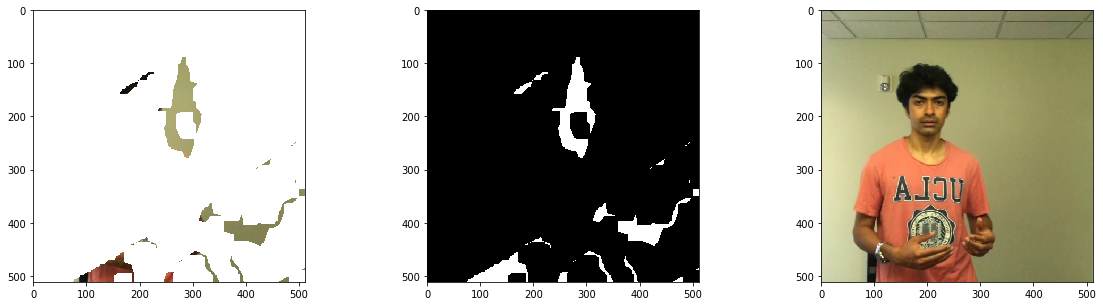

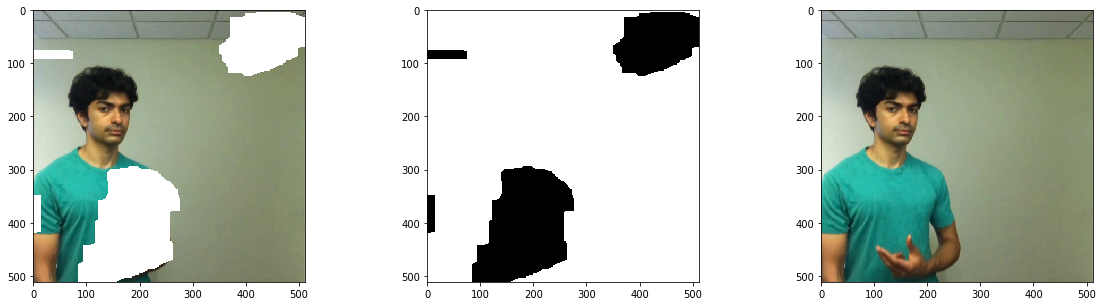

In [0]:
for i in range(len(ori)):
  _, axes = plt.subplots(1,3, figsize=(20,5))
  axes[0].imshow(masked[i,:,:,:])
  axes[1].imshow(mask[i,:,:,:]*1.)
  axes[2].imshow(ori[i,:,:,:])
  plt.show()

In [0]:
PREDICTION_DIR = os.path.join(PCONV_DIR,"prediction-images")

def plot_callback(model, epoch):
  print("epoch ended")
  pred_img = model.predict([ori, mask])
  pred_time = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
  
  
  
  for i in range(len(ori)):
    _, axes = plt.subplots(1, 3, figsize=(20, 5))
    axes[0].imshow(masked[i,:,:,:])
    axes[1].imshow(pred_img[i,:,:,:] * 1.)
    axes[2].imshow(ori[i,:,:,:])
    axes[0].set_title('Masked Image')
    axes[1].set_title('Predicted Image')
    axes[2].set_title('Original Image')
    
    plt.savefig(os.path.join(PREDICTION_DIR,'img_{}_{}.png'.format(i, pred_time)))
    
    if epoch%10==0:
      plt.show()
    
    plt.close()

In [0]:
!mkdir model-weights

mkdir: cannot create directory ‘model-weights’: File exists


In [0]:
MODEL_DIR = os.path.join(PCONV_DIR, "model-weights")

In [0]:
def get_latest_model_weights(subdir="phase1"):
  filelist = list(glob.iglob(os.path.join(MODEL_DIR,subdir, "*.h5")))
  filelist = sorted(filelist, key=os.path.getctime)
  print(filelist[-1])
  return filelist[-1]

In [0]:
#Phase 1 - batch normlization is enabled

model = PConvUnet(vgg_weights=os.path.join(PCONV_DIR, "pytorchvgg.26-1.07.h5"))

# call this only if you have done some training already
latest_weight_file = get_latest_model_weights("phase1")
print("GOT WEIGHT FILE: {0}".format(latest_weight_file))
model.load(latest_weight_file)

W0622 17:18:14.149124 139830260266880 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0622 17:18:14.189870 139830260266880 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0622 17:18:14.206427 139830260266880 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0622 17:18:14.243110 139830260266880 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0622 17:18:23.460716 139830260266880 deprecation_wrapp

/content/drive/My Drive/deep-learning/mirror-selfie/PConv-Keras/model-weights/weights.05-2.47.h5
GOT WEIGHT FILE: /content/drive/My Drive/deep-learning/mirror-selfie/PConv-Keras/model-weights/weights.05-2.47.h5


In [0]:
# always run this with a lower epoch amount when you
# restart training. For some reason, the model.predict
# in plot_callback it says ori or masked are not defined
# tried renaming masked to ori - worked once, didnt work second time???
# tried returning a tuple from AugmentingDataGen and worked once???

def train_phase_one():
  model.fit_generator(
    train_generator,
    steps_per_epoch=17772/BATCH_SIZE,
    validation_data=val_generator,
    validation_steps=2202/BATCH_SIZE,
    epochs=50,
    verbose=1,
    callbacks=[
        ModelCheckpoint(
          os.path.join(MODEL_DIR,'phase1','weights.{epoch:02d}-{loss:.2f}.h5'),
          monitor='val_loss',
          save_best_only=True,
          save_weights_only=True
        ),
        LambdaCallback(
          on_epoch_end=lambda epoch, logs: plot_callback(model, epoch)
        )
    ]
  )

In [0]:
#PHASE 2 - batch normalization is diabled

model = PConvUnet(vgg_weights=os.path.join(PCONV_DIR, "pytorchvgg.26-1.07.h5"))

# call this only if you have done some training already
latest_weight_file = get_latest_model_weights("phase1") #changed this to phase 2 incase training is interrupted during phase2
print("GOT WEIGHT FILE: {0}".format(latest_weight_file))
model.load(latest_weight_file, train_bn=False, lr=0.00005)

In [0]:
# add tensorboard callback if neeeded

def train_phase_two():
  model.fit_generator(
    train_generator,
    steps_per_epoch=17772/BATCH_SIZE,
    validation_data=val_generator,
    validation_steps=2202/BATCH_SIZE,
    epochs=50,
    verbose=1,
    callbacks=[
        ModelCheckpoint(
          os.path.join(MODEL_DIR,'phase2','weights.{epoch:02d}-{loss:.2f}.h5'),
          monitor='val_loss',
          save_best_only=True,
          save_weights_only=True
        ),
        LambdaCallback(
          on_epoch_end=lambda epoch, logs: plot_callback(model, epoch)
        )
    ]
  )

# RUN TRAINING

In [0]:
train_phase_one()

In [0]:
train_phase_two()

# TEST TRAINING

Epoch 1/10
2000/2000 [==============================] - 1374s 687ms/step - loss: 3.4131 - PSNR: 15.6411 - val_loss: 1.7912 - val_PSNR: 19.1476
epoch ended


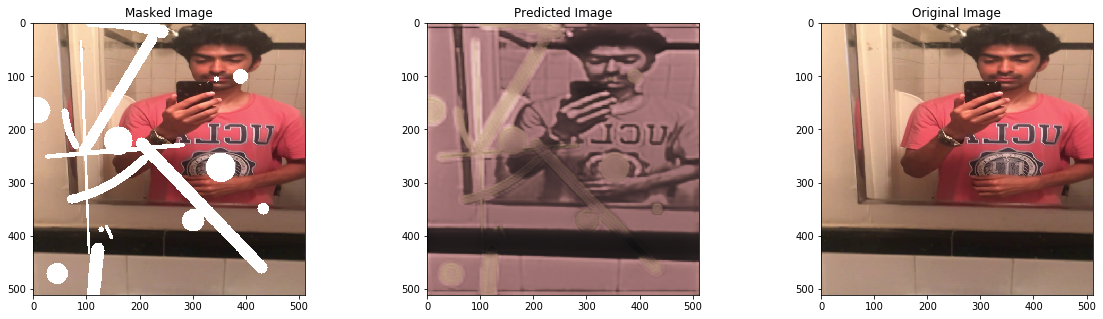

Epoch 2/10
2000/2000 [==============================] - 1370s 685ms/step - loss: 1.7742 - PSNR: 21.1204 - val_loss: 1.5436 - val_PSNR: 21.4143
epoch ended


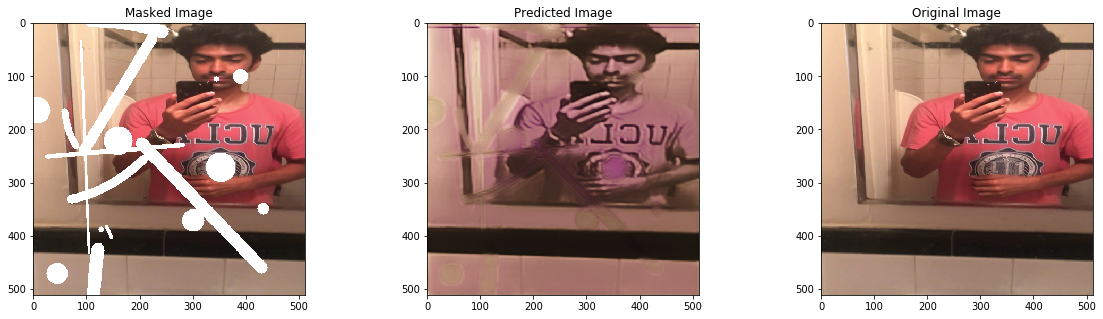

Epoch 3/10
2000/2000 [==============================] - 1370s 685ms/step - loss: 1.4925 - PSNR: 22.5387 - val_loss: 1.2771 - val_PSNR: 23.2336
epoch ended


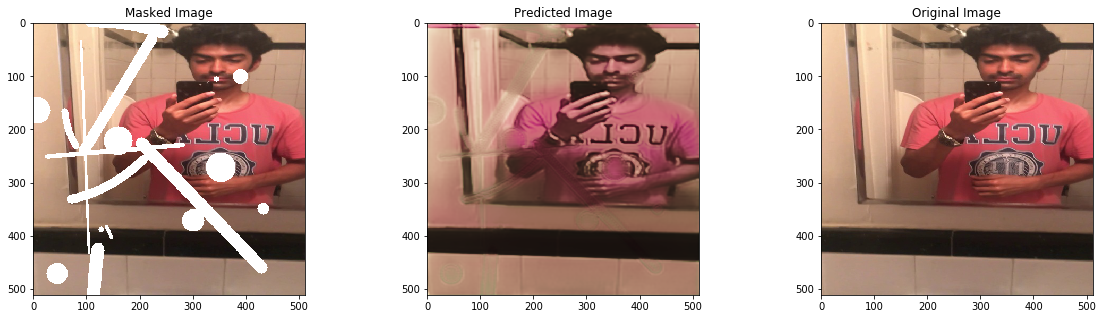

Epoch 4/10
2000/2000 [==============================] - 1373s 686ms/step - loss: 1.2468 - PSNR: 24.1062 - val_loss: 1.1095 - val_PSNR: 24.0309
epoch ended


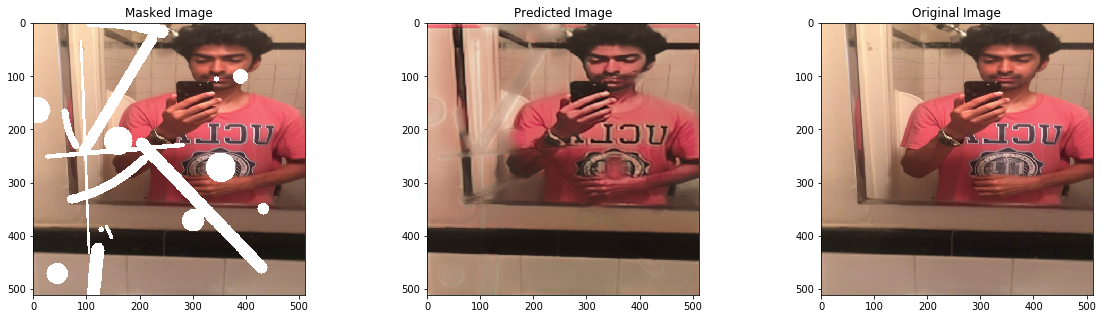

Epoch 5/10
2000/2000 [==============================] - 1373s 687ms/step - loss: 1.1072 - PSNR: 24.9548 - val_loss: 0.9911 - val_PSNR: 25.4179
epoch ended


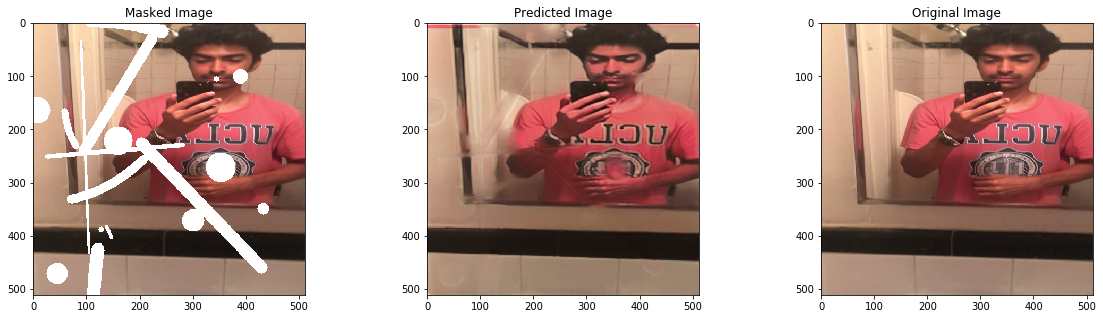

Epoch 6/10
2000/2000 [==============================] - 1380s 690ms/step - loss: 1.0304 - PSNR: 25.2972 - val_loss: 0.9626 - val_PSNR: 25.8647
epoch ended


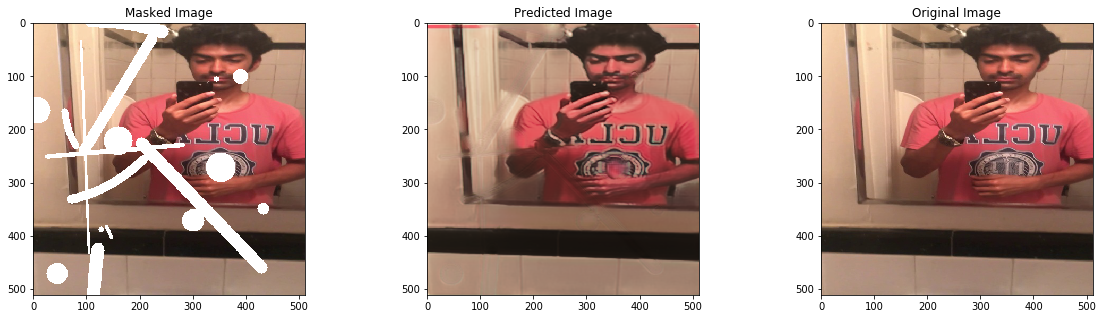

Epoch 7/10
2000/2000 [==============================] - 1381s 691ms/step - loss: 0.9721 - PSNR: 25.6286 - val_loss: 0.8848 - val_PSNR: 27.1458
epoch ended


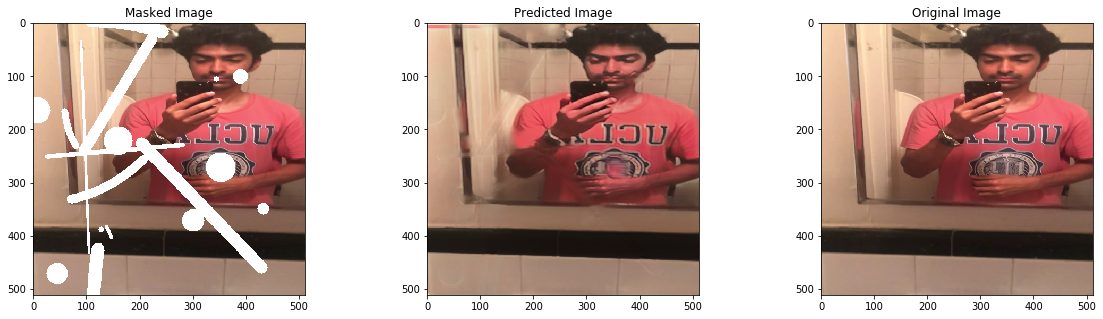

Epoch 8/10
2000/2000 [==============================] - 1379s 690ms/step - loss: 0.9288 - PSNR: 25.8577 - val_loss: 0.8862 - val_PSNR: 27.1291
epoch ended


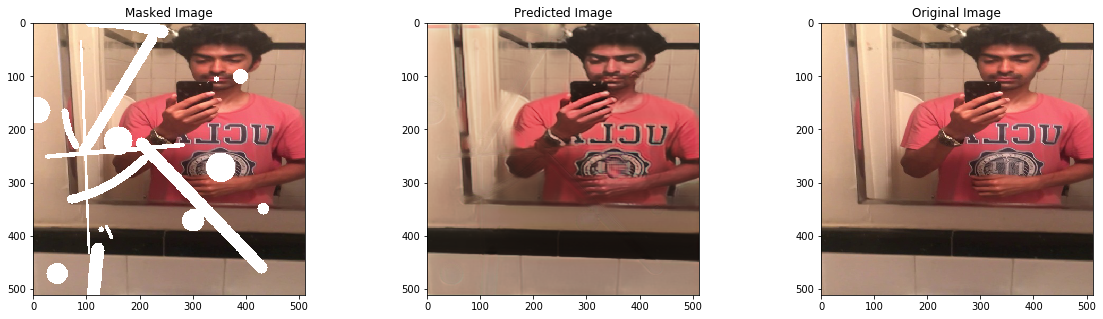

Epoch 9/10
2000/2000 [==============================] - 1381s 691ms/step - loss: 0.8900 - PSNR: 26.0658 - val_loss: 0.8534 - val_PSNR: 27.5399
epoch ended


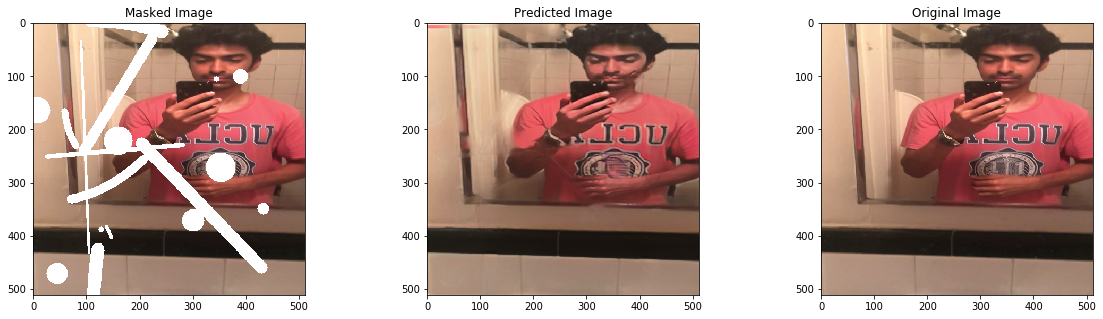

Epoch 10/10
2000/2000 [==============================] - 1381s 691ms/step - loss: 0.8635 - PSNR: 26.2303 - val_loss: 0.8052 - val_PSNR: 27.4016
epoch ended


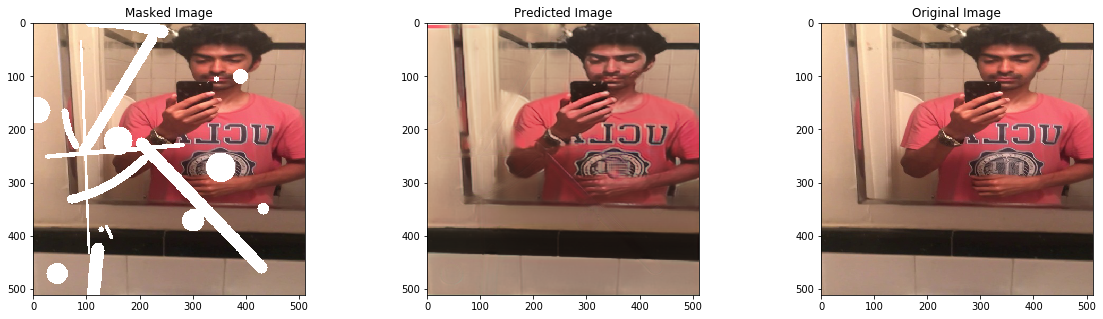

In [0]:
train() #first ten epochs - dont replay this